In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import torchvision.transforms as transforms
from model import VisionTransformer3D
from utils import Crop3D, CTDataset, estimate_global_min_max
from torch.utils.data import DataLoader, random_split,Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
from lploss import LpLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

 # Set random seed for reproducibility
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

# Set device
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")
set_seed(42)

base_dir = f'/rds/general/user/hw123/ephemeral/dataset'

transform = Crop3D((3,224,224))

dataset = CTDataset(base_dir=base_dir,transform=transform)

train_ratio = 0.8
val_ratio = 0.2
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

indices = list(range(total_size))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)


Cuda installed! Running on GPU 0 Quadro RTX 6000!


In [2]:
# Global min: 0, Global max: 65535
global_min, global_max = 0, 65535

In [3]:
model_epoch_predict =  VisionTransformer3D(img_size=(3,224,224), patch_size=(3,16,16),  in_c=2, embed_dim=768, depth=16, num_heads=16, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.).to(device)


checkpoint_path = "model_checkpoint_epoch20.pth"
checkpoint = torch.load(checkpoint_path)

model_epoch_predict.load_state_dict(checkpoint['model_state_dict'])



<All keys matched successfully>

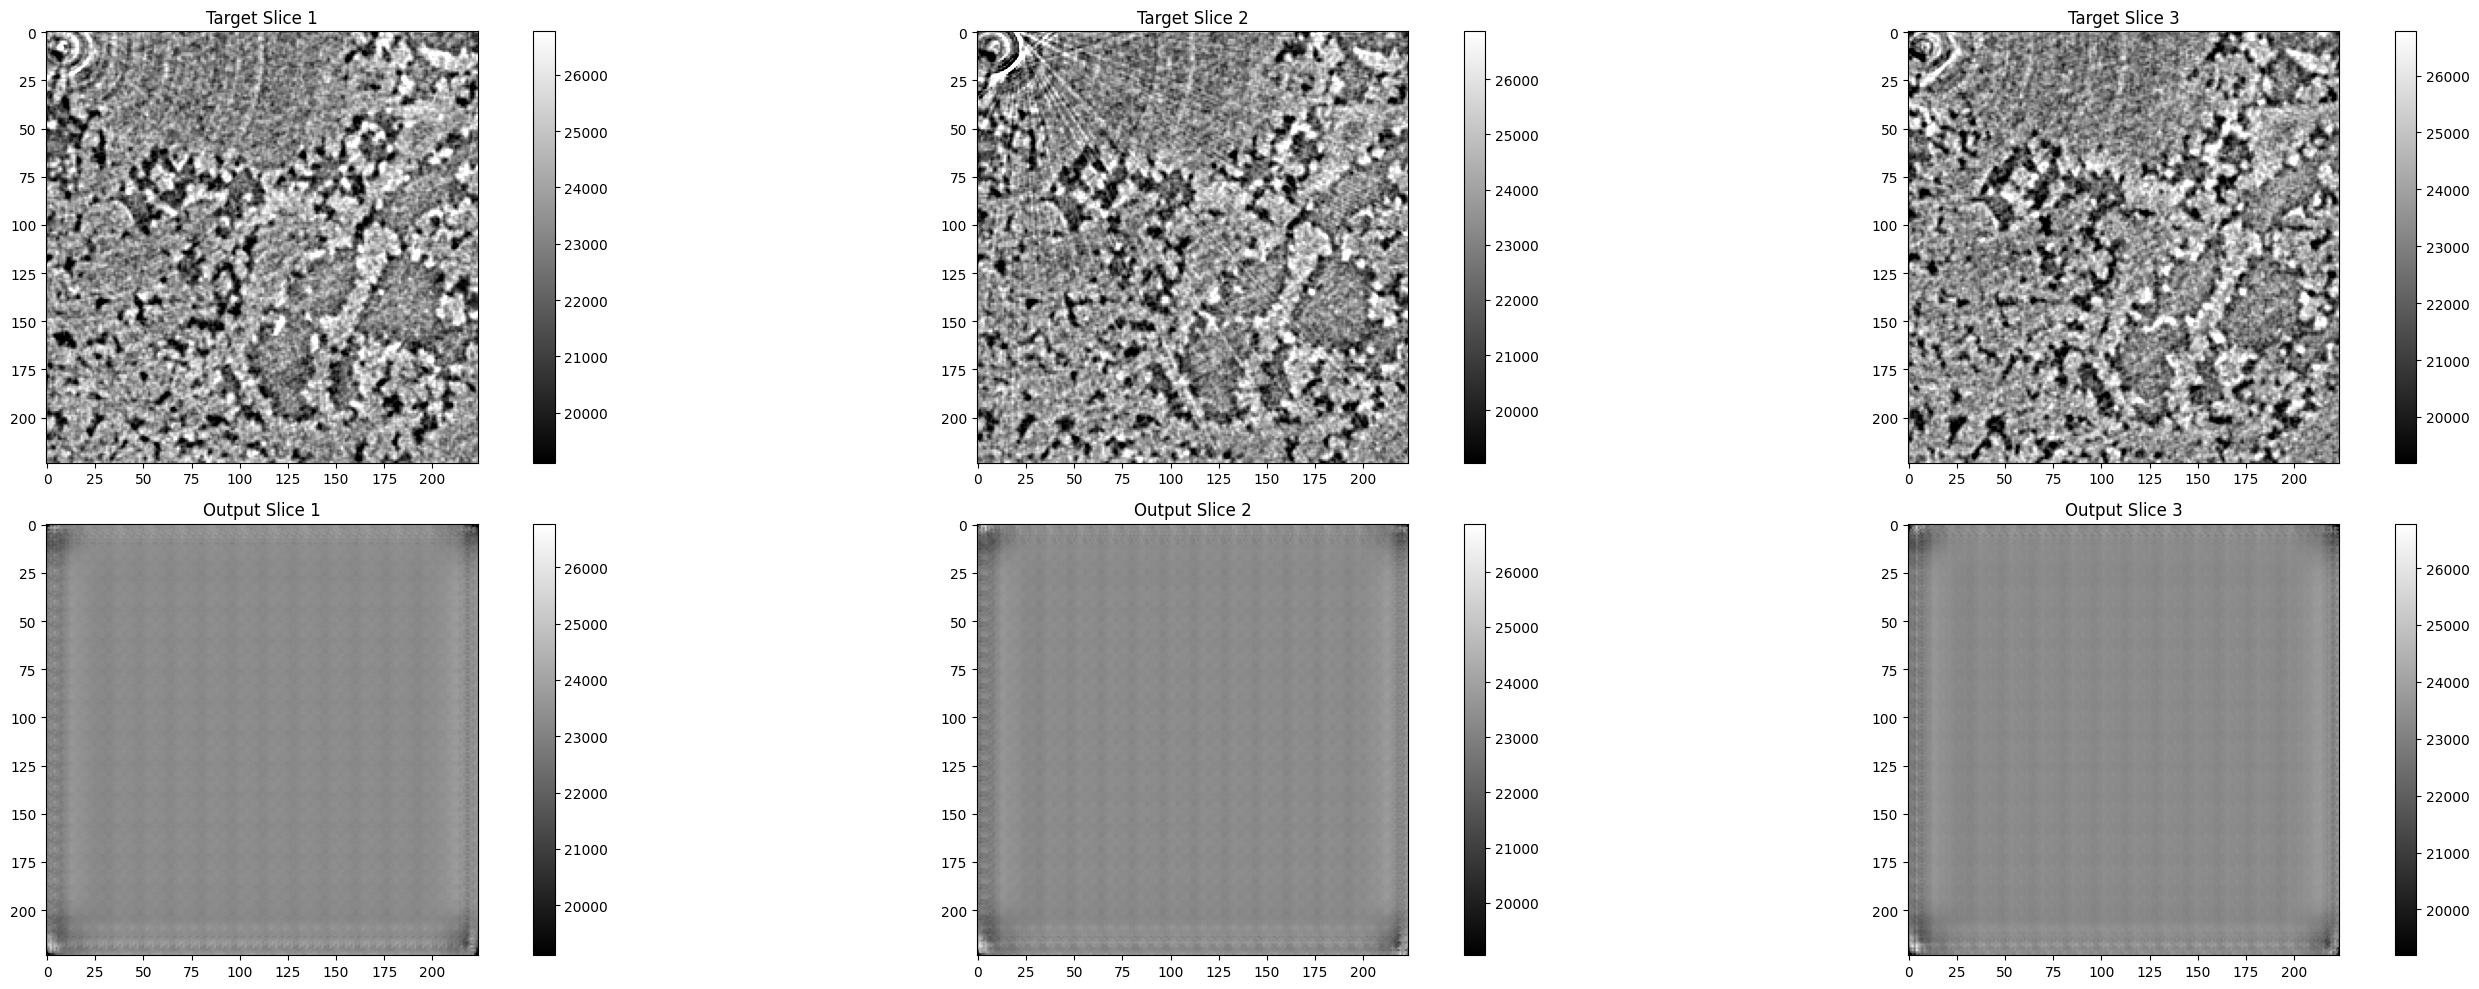

In [6]:
model_epoch_predict.eval()
fig, axes = plt.subplots(2, 3, figsize=(30, 10))
input_val, target_val = val_dataset[0]
input_val, target_val = input_val.unsqueeze(0).to(device), target_val.unsqueeze(0).to(device)

target_val = target_val * (global_max - global_min) + global_min
output_val = model_epoch_predict(input_val)
output_val = output_val * (global_max - global_min) + global_min


for i in range(3):
    target_val_plot = target_val[0, 0, i, :, :].detach().cpu().numpy()
    output_val_plot = output_val[0, 0, i, :, :].detach().cpu().numpy()
    vmin_one_channel = np.percentile(target_val_plot, 2)
    vmax_one_channel = np.percentile(target_val_plot, 98)
    
    
    im1 = axes[0, i].imshow(target_val_plot, cmap='gray',vmin=vmin_one_channel, vmax=vmax_one_channel)
    axes[0, i].set_title(f"Target Slice {i+1}")
    fig.colorbar(im1, ax=axes[0, i])

    im2 = axes[1, i].imshow(output_val_plot, cmap='gray', vmin=vmin_one_channel, vmax=vmax_one_channel)
    axes[1, i].set_title(f"Output Slice {i+1}")
    fig.colorbar(im2, ax=axes[1, i])
plt.tight_layout()
# plt.colorbar()
plt.show()

In [5]:
loss = LpLoss()
loss(output_val,target_val)

tensor(0.0777, device='cuda:0', grad_fn=<MeanBackward0>)

In [6]:
from sklearn.metrics import r2_score


target_val = target_val * (global_max - global_min) + global_min
output_val = output_val * (global_max - global_min) + global_min
# 假设你的 target_val 和 output_val 都是 PyTorch 张量，并且形状相同
target_val_flat = target_val.view(-1).detach().cpu().numpy()
output_val_flat = output_val.view(-1).detach().cpu().numpy()

# 使用 sklearn 计算 R² 值
r2 = r2_score(target_val_flat, output_val_flat)

print(f"R^2: {r2:.4f}")

R^2: -0.0016


tensor([[[[[21130., 25230., 24300.,  ..., 20453., 22134., 23330.],
           [22574., 24910., 25886.,  ..., 20294., 21080., 20663.],
           [23665., 24360., 25215.,  ..., 20064., 20372., 20207.],
           ...,
           [23327., 22767., 22047.,  ..., 23713., 24507., 24482.],
           [22529., 22340., 21792.,  ..., 25479., 25601., 24018.],
           [23234., 23168., 22905.,  ..., 23726., 23818., 23888.]],

          [[18757., 21778., 21233.,  ..., 20745., 20261., 20925.],
           [20716., 22470., 23935.,  ..., 21022., 19688., 19444.],
           [22759., 24906., 26764.,  ..., 20051., 19293., 20023.],
           ...,
           [21344., 21965., 23064.,  ..., 22609., 24310., 24395.],
           [22141., 21593., 21944.,  ..., 24649., 24756., 24612.],
           [22695., 23168., 23670.,  ..., 24058., 25100., 24136.]],

          [[17055., 17744., 18767.,  ..., 21025., 20189., 20633.],
           [18800., 20339., 19805.,  ..., 21321., 19489., 19798.],
           [20378., 21092.